First, create a new conda environment named BI2025 and install the required packages from requirements.txt


In [ ]:
!conda create -n BI2025 python=3.11 -y
!conda activate BI2025
!pip install -r requirements.txt

In [5]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# Note: The only imports allowed are Python's standard library, pandas, numpy, scipy, matplotlib, seaborn and scikit-learn
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import typing
import requests
import time
import shutil
import json
from starvers.starvers import TripleStoreEngine

In [6]:
import os, certifi
os.environ["SSL_CERT_FILE"] = certifi.where()

## Graph-based documentation preliminaries

**!!!IMPORTANT!!!**

Everytime you work on this notebook, enter your student ID in the `executed_by` variable so that the cell executions are accredited to you.

In [7]:
executed_by ='stud-id_12535764'  # Replace the digits after "id_" with your own student ID

Set your group and student IDs. Do this only once.

In [ ]:
# group id for this project
group_id = '059'  # Replace the digits with your group id

# Students working on this notebook
student_a = 'stud-id_12535764'  # Replace the digits after "id_" with student A's student ID
student_b = 'stud-id_11737582'  # Replace the digits after "id_" with student B's student ID

repository_uri = "https://github.com/DanielaKokoneshi/BI2025_gr059_12535764_11737582.git"

In [9]:
# Roles. Don't change these values.
code_writer_role = 'code_writer'
code_executor_role = 'code_executor'

Setup the starvers API for logging your steps into our server-sided graph database.

In [10]:
get_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025"
post_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025/statements"
engine = TripleStoreEngine(get_endpoint, post_endpoint, skip_connection_test=True)

Use these prefixes in your notebooks. You can extend this dict with your prefixes of additional ontologies that you use in this notebook. Replace 00 with your group id

In [ ]:
prefixes = {
    'xsd': 'http://www.w3.org/2001/XMLSchema#',
    'rdfs': 'http://www.w3.org/2000/01/rdf-schema#',
    'foaf': 'http://xmlns.com/foaf/0.1/',
    'prov': 'http://www.w3.org/ns/prov#',
    'sc': 'https://schema.org/',
    'cr': 'http://mlcommons.org/croissant/',
    'mls': 'http://www.w3.org/ns/mls#',
    'mlso': 'http://w3id.org/mlso',
    'siu': 'https://si-digital-framework.org/SI/units/',
    'siq': 'https://si-digital-framework.org/SI/quantities/',
    'qudt': 'http://qudt.org/schema/qudt/',
    '': f'https://starvers.ec.tuwien.ac.at/BI2025/{59}/',
}

prefix_header = '\n'.join([f'PREFIX {k}: <{v}>' for k, v in prefixes.items()]) + '\n\n'

Ontologies to use
* Provenance of the experiment process
    * PROV-O: 
        * doc: https://www.w3.org/TR/prov-o/
        * serialization: https://www.w3.org/ns/prov-o
* Data used and created
    * schema.org - Dataset: 
        * doc: https://schema.org/Dataset
        * serialization: https://schema.org/version/latest/schemaorg-current-https.ttl
    * Crossaint
        * doc: https://docs.mlcommons.org/croissant/docs/croissant-spec.html
        * serialization: https://github.com/mlcommons/croissant/blob/main/docs/croissant.ttl
* ML experiments performed
    * MLSO: 
        * doc: https://github.com/dtai-kg/MLSO
        * doc: https://dtai-kg.github.io/MLSO/#http://w3id.org/
        * serialization: https://dtai-kg.github.io/MLSO/ontology.ttl
* Measurements, Metrics, Units
    * QUDT
        * doc:https://qudt.org/
        * doc: https://github.com/qudt/qudt-public-repo
        * serialization: https://github.com/qudt/qudt-public-repo/blob/main/src/main/rdf/schema/SCHEMA_QUDT.ttl
    * SI Digital Framework
        * doc: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/docs/README.md
        * doc: https://si-digital-framework.org/
        * doc: https://si-digital-framework.org/SI
        * serialization: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/TTL/si.ttl
    * Quantities and Units
        * doc: https://www.omg.org/spec/Commons
        * serialization: https://www.omg.org/spec/Commons/QuantitiesAndUnits.ttl

Use this function to record execution times.

In [12]:
def now() -> str:
    """
    Returns the current time in ISO 8601 format with UTC timezone in the following format:
    YYYY-MM-DDTHH:MM:SS.sssZ
    """
    timestamp = datetime.datetime.now(datetime.timezone.utc)
    timestamp_formated = timestamp.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]  +"Z"

    return timestamp_formated

Register yourself in the Knowledge Graph using ProvO. Change the given name, family name and immatriculation number to reflect your own data.

In [ ]:
# Ontologies used: foaf, prov, IAO
reigstration_triples_a = [
f':{student_a} rdf:type foaf:Person .',
f':{student_a} rdf:type prov:Agent .',
f':{student_a} foaf:givenName "Daniela" .',
f':{student_a} foaf:familyName "Kokoneshi" .',
f':{student_a} <http://vivoweb.org/ontology/core#identifier> :{student_a} .',
f':{student_a} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_a} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_a} <http://purl.obolibrary.org/obo/IAO_0000219> "12535764"^^xsd:string .',
]

reigstration_triples_b = [
f':{student_b} rdf:type foaf:Person .',
f':{student_b} rdf:type prov:Agent .',
f':{student_b} foaf:givenName "Keisi" .',
f':{student_b} foaf:familyName "Cela" .',
f':{student_b} <http://vivoweb.org/ontology/core#identifier> :{student_b} .',
f':{student_b} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_b} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_b} <http://purl.obolibrary.org/obo/IAO_0000219> "11737582"^^xsd:string .',
]

role_triples = [
    f':{code_writer_role} rdf:type prov:Role .',
    f':{code_executor_role} rdf:type prov:Role .',
]


engine.insert(reigstration_triples_a, prefixes=prefixes)
engine.insert(reigstration_triples_b, prefixes=prefixes)
engine.insert(role_triples, prefixes=prefixes)

**What not do do**

Do not use [blank nodes](https://www.w3.org/wiki/BlankNodes).

PROV-O uses blank nodes to connect multiple elements with each other.
Such blank nodes (such as _:association) should not be used.
Instead, assign a fixed node ID such as
:5119fcd7-b571-41e0-9464-a37c7be0f574 by generating them outside of the
notebook.
We suggest that, for each setting where such a blank node is needed to
connect multiple elements, you create a unique hash (using uuid.uuid4())
and keep this as hard-coded identifier for the blank node. The template
notebook contains examples of this. Do *not* use these provided values,
as otherwise, your provenance documentations will all be connected via
these identifiers!
Also, do not generate them dynamically in every cell execution, e.g. by
using uuid.uuid4() in a cell. This would generate many new linking nodes
for connecting the same elements.
Compute one for each node (cell) where you need them and make sure to
use the same one on each re-execution of the notebook.

In [45]:
weather_data_path = os.path.join("data", "datasets", "weather")
cyclists_data_path = os.path.join("data", "datasets", "cyclists")

## Business Understanding 

In [46]:
## Each Activity that follows is part of the Business Understanding Phase

business_understanding_phase_executor = [
f':business_understanding_phase rdf:type prov:Activity .',
f':business_understanding_phase rdfs:label "Business Understanding Phase" .', ## Phase 1: Business Understanding
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


In [29]:
#############################################
# Documentation
#############################################

data_src_and_scenario_comment = """
The colloges_usnews dataset used for this poject is gotten from OpenML.
It is a real-world dataset, from the American Statistical Association's
1995 Data Analysis Exposition,based on insitutional data published in U.S
News and World Report`s Guide to America`s Best Colleges (1993-1994).
It contains information for 1,302 U.S colleges and universities,
including variables related to admission selectivity (SAT/ACT scores,
application acceptance), institutional characterisitcs (public/private,
tuition, spending), student composition,faculty qualification and outcomes
such as graduation rate. In total the dataset has a total of 35 attributes
with most of them being numeric, and some being categorical such as state,
public/private. The dataset contains missing values, particularly in the
test score variables making it a realistic analysis.

A suitable business scenraio for this dataset would be a university
administration seeking to understand what factors influence graduation rates.
By applying data analytics processess to the dataset, the institution can
identify patterns and understand what factors influence a higher graduation rate.
This analysis can support strategic planning, rescource allocation and performance
benchmarking. """

business_objectives_comment = """
The main objective of this analysis is to define which of the variables
have a higher impact on the graduation rate of students. By identifying
these factors the institutions have the necessary information to improve
students sucess. Other objectives include providing universities with
benchmarks against similar institution, identifying what aspects would
have the biggest turn on investments and understaning how admission selectivity
or student preparedness relate to graduation outcomes.

All these objectives support organizations in making informed strategic decisions.

"""

business_success_criteria_comment = """
For this project to be called successful, it should produce  precise
 and easily interpretable insights regarding the key factors that influence
 the graduation rate as well as a model that accuratly predicts
the graduation rate of an institution based on the provided features. Another
measure of sucess for this analysis would be that the derived recommendations
are actionable, such as identifying which variables universities should
influence to improve outcomes.

Additionally, the results should be presented in a way  that universities
can easily use the results for benchmarking, this way they can easily
compare their performance against other educational institutions.
"""

data_mining_goals_comment = """
The main data mining goal is to build a predictive model that estimates
an institution`s graduation rate based on the available institutional,
financial and student-related variables in the dataset. The model should
provide accurate predictions, as well as highlight which features
contribute most strongly to higher or lower graduation rates. Another
goal is to perform exploratory analysis to better understand the relationshipps
between variables such as tuition, selectivity, spending per student,
or faculty resources and the graduation rate.This supports the business
objective of identifying concrete levers that universities can influence
 to improve student successs.
"""

data_mining_success_criteria_comment = """
From a data mining perspective, the project is considered successful if
we can train a regression model that generalizes well and explains an important
 part of the variance in graduation rates. We are trying to have a model that
 achieves a high coefficient of determination and a low prediction error
 when testing via cross-validation.In addition, the learned model and derived
 feature importance measures should be interpretable for non-technical stakeholders.
 Key factors influencing graduation rate should be distinctly identifiable
 (similar across different validation splits), so that they can be translated
 into recommendations and benchmarking indicators for universities.
"""

ai_risk_aspects_comment = """
This project uses institutional-level, historical data about colleges and
universities. While the dataset does not contain personal student identifiers,
there are still some AI-related risks to consider. First, the data may reflect
existing structural inequalities (between public and private institutions or
between different regions). A model trained on such data could unintentionally
reinforce these patterns if its predictions are used for funding decisions,
 rankings or policy making without careful interpretation. Second, there is
 a risk of over-interpreting correlations as causal effects and using the
 model as a black-box decision tool rather than as analytic support. To handle
  these risks, the focus of the project is on transparency and interpretability
  (using explainable models and feature importance analysis), precisely
  communicating the limitations of the data and the model, and treating the
  results as decision-support for experts rather than automatic decision-making.
"""

bu_ass_uuid_executor = "b27d10e0-43ca-4c0c-b027-3c63af750a3d" # Generate once
business_understanding_executor = [
f':business_understanding rdf:type prov:Activity .',
f':business_understanding sc:isPartOf :business_understanding_phase .', # Connect Activity to Parent Business Understanding Phase Activity
f':business_understanding prov:qualifiedAssociation :{bu_ass_uuid_executor} .',
f':{bu_ass_uuid_executor} prov:agent :{executed_by} .',
f':{bu_ass_uuid_executor} rdf:type prov:Association .',
f':{bu_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(business_understanding_executor, prefixes=prefixes)

business_understanding_data_executor = [
# 1a
f':bu_data_source_and_scenario rdf:type prov:Entity .',
f':bu_data_source_and_scenario prov:wasGeneratedBy :business_understanding .',
f':bu_data_source_and_scenario rdfs:label "1a Data Source and Scenario" .',
f':bu_data_source_and_scenario rdfs:comment """{data_src_and_scenario_comment}""" .',
# 1b
f':bu_business_objectives rdf:type prov:Entity .',
f':bu_business_objectives prov:wasGeneratedBy :business_understanding .',
f':bu_business_objectives rdfs:label "1b Business Objectives" .',
f':bu_business_objectives rdfs:comment """{business_objectives_comment}""" .',
# 1c
f':bu_business_success_criteria rdf:type prov:Entity .',
f':bu_business_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_business_success_criteria rdfs:label "1c Business Success Criteria" .',
f':bu_business_success_criteria rdfs:comment """{business_success_criteria_comment}""" .',
# 1d
f':bu_data_mining_goals rdf:type prov:Entity .',
f':bu_data_mining_goals prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_goals rdfs:label "1d Data Mining Goals" .',
f':bu_data_mining_goals rdfs:comment """{data_mining_goals_comment}""" .',
# 1e
f':bu_data_mining_success_criteria rdf:type prov:Entity .',
f':bu_data_mining_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_success_criteria rdfs:label "1e Data Mining Success Criteria" .',
f':bu_data_mining_success_criteria rdfs:comment """{data_mining_success_criteria_comment}""" .',
# 1f
f':bu_ai_risk_aspects rdf:type prov:Entity .',
f':bu_ai_risk_aspects prov:wasGeneratedBy :business_understanding .',
f':bu_ai_risk_aspects rdfs:label "1f AI risk aspects" .',
f':bu_ai_risk_aspects rdfs:comment """{ai_risk_aspects_comment}""" .',

]
engine.insert(business_understanding_data_executor, prefixes=prefixes)

## Data Understanding

The following pseudo-code & pseudo-documentation may be used as a hint.

In [14]:
## Each Activity that follows is part of the Data Understanding Phase

business_understanding_phase_executor = [
f':data_understanding_phase rdf:type prov:Activity .',
f':data_understanding_phase rdfs:label "Data Understanding Phase" .', 
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


EndPointInternalError: EndPointInternalError: The endpoint returned the HTTP status code 500. 

Response:
b'java.lang.StackOverflowError'

In [54]:
import requests
import pandas as pd
import arff


# Student responsible for this code
load_college_data_code_writer = student_b

def load_college_data() -> pd.DataFrame:
    url = "https://www.openml.org/data/download/52650/colleges_usnews.arff"
    arff_text = requests.get(url).text
    arff_data = arff.loads(arff_text)

    # Extract dataframe
    columns = [attr[0] for attr in arff_data["attributes"]]
    df = pd.DataFrame(arff_data["data"], columns=columns)

    return df, arff_data

# loading
start_time_ld = now()
data, openml_bunch = load_college_data()
end_time_ld = now()

display(data.head())
print("Shape:", data.shape)
print("Columns:", list(data.columns))
print("OpenML name:", getattr(openml_bunch, "name", None))

# making sure graduation_rate is still there, even with missed values
if "Graduation_rate" in data.columns:
    print("Graduation_rate NaNs:", data["Graduation_rate"].isna().sum())

#############################################
# Documentation 2a: raw data + dataset description
#############################################

# loading the dataset (executor)
du_ld_ass_uuid_executor = "du_load_exec_538"
engine.insert([
    f':load_college_data prov:qualifiedAssociation :{du_ld_ass_uuid_executor} .',
    f':{du_ld_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{du_ld_ass_uuid_executor} rdf:type prov:Association .',
    f':{du_ld_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
], prefixes=prefixes)

# Activity + writer (who wrote the code)
du_ld_ass_uuid_writer = "du_load_writer_538"

dataset_description = """
The dataset contains U.S. colleges and universities derived from US News & World Report.
Each row represents one institution and the columns describe selectivity, resources,
financial indicators and student outcomes such as graduation rate.
"""

engine.insert([
    ':load_college_data rdf:type prov:Activity .',
    ':load_college_data sc:isPartOf :data_understanding_phase .',
    f':load_college_data rdfs:comment """Loading OpenML dataset 538 (colleges_usnews) into a pandas DataFrame.""" .',
    f':load_college_data prov:startedAtTime "{start_time_ld}"^^xsd:dateTime .',
    f':load_college_data prov:endedAtTime "{end_time_ld}"^^xsd:dateTime .',
    f':load_college_data prov:qualifiedAssociation :{du_ld_ass_uuid_writer} .',
    f':{du_ld_ass_uuid_writer} prov:agent :{load_college_data_code_writer} .',
    f':{du_ld_ass_uuid_writer} rdf:type prov:Association .',
    f':{du_ld_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    ':openml_source_538 rdf:type prov:Entity .',
    ':openml_source_538 rdfs:label "OpenML dataset 538 (colleges_usnews)" .',
    ':load_college_data prov:used :openml_source_538 .',
    ':raw_data rdf:type prov:Entity .',
    ':raw_data rdf:type sc:Dataset .',
    ':raw_data sc:name "US Colleges (US News) dataset" .',
    f':raw_data sc:description """{dataset_description}""" .',
    ':raw_data prov:wasGeneratedBy :load_college_data .',
], prefixes=prefixes)

#############################################
# Croissant description of fields (2a: attributes & types)
#############################################

def dtype_to_xsd(dtype) -> str:
    s = str(dtype)
    if "int" in s:
        return "xsd:integer"
    if "float" in s:
        return "xsd:double"
    if "bool" in s:
        return "xsd:boolean"
    return "xsd:string"


recordset_id = ":raw_recordset"

field_triples = [
    ":raw_data cr:recordSet :raw_recordset .",
    ":raw_recordset rdf:type cr:RecordSet .",
    ":raw_recordset sc:name 'US Colleges raw table' .",
]

for col in data.columns:
    safe_col = str(col).replace(" ", "_").replace("/", "_").replace("%", "pct")
    fid = f":field_{safe_col}"
    field_triples += [
        f"{recordset_id} cr:field {fid} .",
        f"{fid} rdf:type cr:Field .",
        f"{fid} sc:name '{col}' .",
        f"{fid} cr:dataType {dtype_to_xsd(data[col].dtype)} .",
        f"{fid} sc:description 'Auto-generated: column {col} from OpenML 538.' .",
    ]

engine.insert(field_triples, prefixes=prefixes)

,FICE,College_name,State,Public/private_indicator,Average_Math_SAT_score,Average_Verbal_SAT_score,Average_Combined_SAT_score,Average_ACT_score,First_quartile-Math_SAT,Third_quartile-Math_SAT,...,Board_costs,Additional_fees,Estimated_book_costs,Estimated_personal_spending,Pct._of_faculty_with_Ph.D.s,Pct._of_faculty_with_terminal_degree,Student/faculty_ratio,Pct.alumni_who_donate,Instructional_expenditure_per_student,Graduation_rate
0,1061,Alaska_Pacific_University,AK,2,490.0,482.0,972.0,20.0,440.0,530.0,...,2500.0,130.0,800.0,1500.0,76.0,72.0,119.0,2.0,10922.0,15.0
1,1063,University_of_Alaska_at_Fairbanks,AK,1,499.0,462.0,961.0,22.0,NaN,NaN,...,1790.0,155.0,650.0,2304.0,67.0,NaN,100.0,8.0,11935.0,NaN
2,1065,University_of_Alaska_Southeast,AK,1,NaN,NaN,NaN,NaN,NaN,NaN,...,2250.0,34.0,500.0,1162.0,39.0,51.0,95.0,NaN,9584.0,39.0
3,11462,University_of_Alaska_at_Anchorage,AK,1,459.0,422.0,881.0,20.0,NaN,NaN,...,2520.0,114.0,580.0,1260.0,48.0,NaN,137.0,6.0,8046.0,NaN
4,1002,Alabama_Agri__and__Mech_Univ,AL,1,NaN,NaN,NaN,17.0,NaN,NaN,...,1442.0,155.0,500.0,850.0,53.0,53.0,143.0,NaN,7043.0,40.0


Shape: (1302, 35)
Columns: ['FICE', 'College_name', 'State', 'Public/private_indicator', 'Average_Math_SAT_score', 'Average_Verbal_SAT_score', 'Average_Combined_SAT_score', 'Average_ACT_score', 'First_quartile-Math_SAT', 'Third_quartile-Math_SAT', 'First_quartile-Verbal_SAT', 'Third_quartile-Verbal_SAT', 'First_quartile-ACT', 'Third_quartile-ACT', 'Number_of_applications_received', 'Number_of_applicants_accepted', 'Number_of_new_students_enrolled', 'Pct._new_students_from_top_10Perc_of_H.S._class', 'Pct._new_students_from_top_25Perc_of_H.S._class', 'Number_of_fulltime_undergraduates', 'Number_of_parttime_undergraduates', 'In-state_tuition', 'Out-of-state_tuition', 'Room_and_board_costs', 'Room_costs', 'Board_costs', 'Additional_fees', 'Estimated_book_costs', 'Estimated_personal_spending', 'Pct._of_faculty_with_Ph.D.s', 'Pct._of_faculty_with_terminal_degree', 'Student/faculty_ratio', 'Pct.alumni_who_donate', 'Instructional_expenditure_per_student', 'Graduation_rate']
OpenML name: None
G

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
State,1302,51,NY,101,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Public/private_indicator,1302.0,NaN,NaN,NaN,1.639017,0.48047,1.0,1.0,2.0,2.0,2.0
Average_Math_SAT_score,777.0,NaN,NaN,NaN,506.837838,67.822441,320.0,460.0,500.0,544.0,750.0
Average_Verbal_SAT_score,777.0,NaN,NaN,NaN,461.223938,58.298413,280.0,422.0,457.0,492.0,665.0
Average_Combined_SAT_score,779.0,NaN,NaN,NaN,967.978177,123.577493,600.0,884.5,957.0,1038.0,1410.0
Average_ACT_score,714.0,NaN,NaN,NaN,22.120448,2.579899,11.0,20.25,22.0,24.0,31.0
First_quartile-Math_SAT,772.0,NaN,NaN,NaN,462.235751,76.32264,220.0,410.0,453.0,510.0,740.0
Third_quartile-Math_SAT,772.0,NaN,NaN,NaN,583.148964,71.217974,330.0,530.0,580.0,630.0,785.0
First_quartile-Verbal_SAT,772.0,NaN,NaN,NaN,418.487047,64.492038,200.0,380.0,410.0,450.0,630.0
Third_quartile-Verbal_SAT,772.0,NaN,NaN,NaN,530.452073,64.536813,330.0,480.0,530.0,570.0,720.0



Number of numeric columns: 32


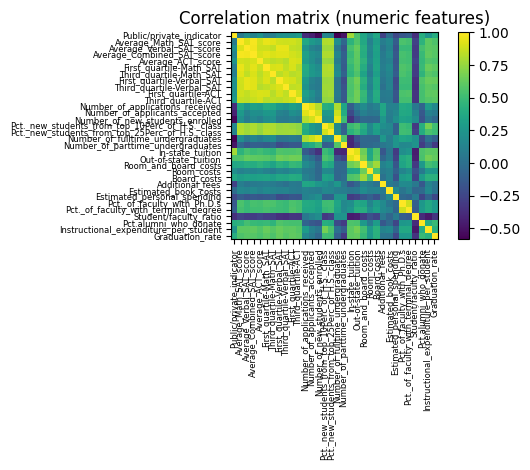

In [64]:
#############################################
# 2b: Descriptive statistics & correlation
#############################################

du_stats_code_writer = student_b
start_time_stats = now()
desc_all = data.describe(include="all").transpose()

# matrix for numeric features
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
corr = data[numeric_cols].corr(numeric_only=True)

end_time_stats = now()

display(desc_all.head(20))
print("\nNumber of numeric columns:", len(numeric_cols))

plt.figure()
plt.imshow(corr.values)
plt.title("Correlation matrix (numeric features)")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=6)
plt.yticks(range(len(corr.columns)), corr.columns, fontsize=6)
plt.colorbar()
plt.tight_layout()
plt.show()

# Documentation in KG
du_stats_ass_uuid_exec = "du_stats_exec_538"
du_stats_ass_uuid_writer = "du_stats_writer_538"

# Executor
engine.insert([
    f':du_statistics prov:qualifiedAssociation :{du_stats_ass_uuid_exec} .',
    f':{du_stats_ass_uuid_exec} prov:agent :{executed_by} .',
    f':{du_stats_ass_uuid_exec} rdf:type prov:Association .',
    f':{du_stats_ass_uuid_exec} prov:hadRole :{code_executor_role} .',
], prefixes=prefixes)

stats_comment = f"""
Computed descriptive statistics (describe(include='all')) for all columns and
a correlation matrix for {len(numeric_cols)} numeric features.
"""

engine.insert([
    ':du_statistics rdf:type prov:Activity .',
    ':du_statistics sc:isPartOf :data_understanding_phase .',
    f':du_statistics rdfs:comment """{stats_comment}""" .',
    f':du_statistics prov:startedAtTime "{start_time_stats}"^^xsd:dateTime .',
    f':du_statistics prov:endedAtTime "{end_time_stats}"^^xsd:dateTime .',
    f':du_statistics prov:qualifiedAssociation :{du_stats_ass_uuid_writer} .',
    f':{du_stats_ass_uuid_writer} prov:agent :{du_stats_code_writer} .',
    f':{du_stats_ass_uuid_writer} rdf:type prov:Association .',
    f':{du_stats_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    ':du_statistics prov:used :raw_data .',

    ':du_stats_report rdf:type prov:Entity .',
    ':du_stats_report prov:wasGeneratedBy :du_statistics .',
    f':du_stats_report rdfs:comment """Head of describe() (first 20 rows) for all columns.""" .',
], prefixes=prefixes)

In [65]:
#############################################
# 2c: Data quality (missing values, simple outliers)
#############################################

du_stats_code_writer = student_b

start_time_quality = now()

# missing values per column
missing = data.isna().sum().sort_values(ascending=False)
missing_nonzero = missing[missing > 0]

print("Columns with missing values:", missing_nonzero.shape[0])
display(missing_nonzero.head(30))

# outlier detection using IQR per numeric column
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
outlier_counts = {}

for col in numeric_cols:
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    if iqr == 0 or pd.isna(iqr):
        continue
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    mask = (data[col] < lower) | (data[col] > upper)
    outlier_counts[col] = int(mask.sum())

outlier_summary = pd.Series(outlier_counts).sort_values(ascending=False)
print("\nOutlier counts per numeric column (top 15):")
display(outlier_summary.head(15))

end_time_quality = now()

# Documentation in KG
du_quality_ass_uuid_exec = "du_quality_exec_538"
du_quality_ass_uuid_writer = "du_quality_writer_538"

quality_comment = f"""
Checked data quality: counted missing values per column and identified potential
outliers per numeric column using the IQR rule (1.5*IQR outside [Q1, Q3]).
Found {missing_nonzero.shape[0]} columns with at least one missing value.
"""

engine.insert([
    ':du_quality rdf:type prov:Activity .',
    ':du_quality sc:isPartOf :data_understanding_phase .',
    f':du_quality rdfs:comment """{quality_comment}""" .',
    f':du_quality prov:startedAtTime "{start_time_quality}"^^xsd:dateTime .',
    f':du_quality prov:endedAtTime "{end_time_quality}"^^xsd:dateTime .',
    f':du_quality prov:qualifiedAssociation :{du_quality_ass_uuid_writer} .',
    f':{du_quality_ass_uuid_writer} prov:agent :{student_a} .',
    f':{du_quality_ass_uuid_writer} rdf:type prov:Association .',
    f':{du_quality_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    ':du_quality prov:used :raw_data .',

    ':missing_values_report rdf:type prov:Entity .',
    ':missing_values_report prov:wasGeneratedBy :du_quality .',
    f':missing_values_report rdfs:comment """Top columns with missing values: {list(missing_nonzero.head(10).index)}.""" .',

    ':outlier_summary_report rdf:type prov:Entity .',
    ':outlier_summary_report prov:wasGeneratedBy :du_quality .',
    f':outlier_summary_report rdfs:comment """Outlier counts per numeric column (top 10): {outlier_summary.head(10).to_dict()}""" .',
], prefixes=prefixes)

Columns with missing values: 31


Third_quartile-ACT                                 639
First_quartile-ACT                                 639
Average_ACT_score                                  588
First_quartile-Math_SAT                            530
First_quartile-Verbal_SAT                          530
Third_quartile-Math_SAT                            530
Third_quartile-Verbal_SAT                          530
Average_Math_SAT_score                             525
Average_Verbal_SAT_score                           525
Average_Combined_SAT_score                         523
Board_costs                                        498
Room_costs                                         321
Additional_fees                                    274
Pct._new_students_from_top_10Perc_of_H.S._class    235
Pct.alumni_who_donate                              222
Pct._new_students_from_top_25Perc_of_H.S._class    202
Estimated_personal_spending                        181
Graduation_rate                                     98
Room_and_b


Outlier counts per numeric column (top 15):


Number_of_fulltime_undergraduates                  124
Number_of_applications_received                    121
Number_of_parttime_undergraduates                  119
Number_of_applicants_accepted                      105
Number_of_new_students_enrolled                    103
Estimated_book_costs                                95
Instructional_expenditure_per_student               84
Pct._new_students_from_top_10Perc_of_H.S._class     60
Additional_fees                                     55
Room_costs                                          47
First_quartile-Verbal_SAT                           35
Average_Verbal_SAT_score                            28
Estimated_personal_spending                         24
Student/faculty_ratio                               22
Average_Combined_SAT_score                          20
dtype: int64

Chosen target-like column for visualization: Number_of_fulltime_undergraduates


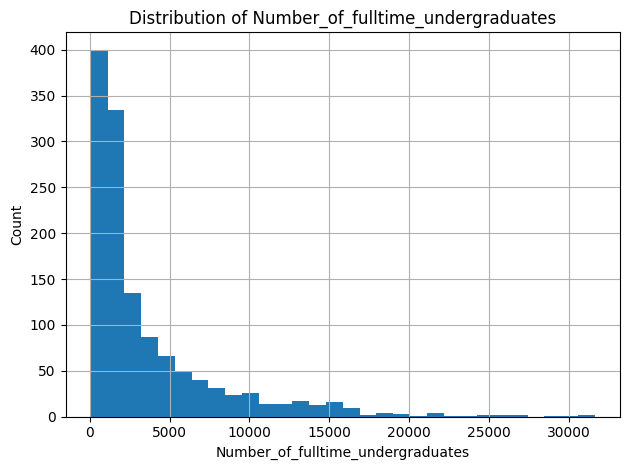

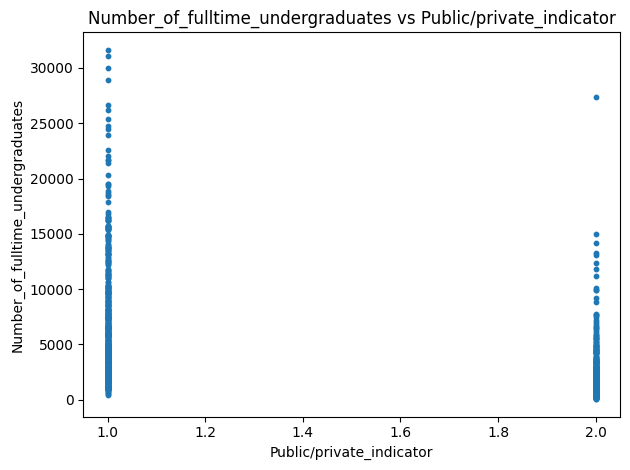

In [66]:
#############################################
# 2d: Visual exploration (distributions / relationships)
#############################################

du_stats_code_writer = student_b

start_time_viz = now()

numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()

# trying to guess a target-like variable (graduation rate)
target_candidates = [c for c in data.columns if "grad" in c.lower()]
if target_candidates:
    target_col = target_candidates[0]
elif numeric_cols:
    target_col = numeric_cols[0]
else:
    target_col = None

print("Chosen target-like column for visualization:", target_col)

if target_col is not None:
    plt.figure()
    data[target_col].hist(bins=30)
    plt.title(f"Distribution of {target_col}")
    plt.xlabel(target_col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # have another numeric feature for scatter / relationship
    feature_candidates = [c for c in numeric_cols if c != target_col]
    if feature_candidates:
        feature_col = feature_candidates[0]
        plt.figure()
        plt.scatter(data[feature_col], data[target_col], s=10)
        plt.title(f"{target_col} vs {feature_col}")
        plt.xlabel(feature_col)
        plt.ylabel(target_col)
        plt.tight_layout()
        plt.show()
    else:
        feature_col = None
else:
    feature_col = None

end_time_viz = now()

# Documentation in KG
du_viz_ass_uuid_exec = "du_viz_exec_538"
du_viz_ass_uuid_writer = "du_viz_writer_538"

viz_comment = f"""
Visual exploration of the dataset: plotted a histogram for the target-like column '{target_col}'
(if available) and a scatter plot of '{target_col}' versus '{feature_col}' (if available) to inspect
distributions and simple relationships.
"""

engine.insert([
    ':du_visual_exploration rdf:type prov:Activity .',
    ':du_visual_exploration sc:isPartOf :data_understanding_phase .',
    f':du_visual_exploration rdfs:comment """{viz_comment}""" .',
    f':du_visual_exploration prov:startedAtTime "{start_time_viz}"^^xsd:dateTime .',
    f':du_visual_exploration prov:endedAtTime "{end_time_viz}"^^xsd:dateTime .',
    f':du_visual_exploration prov:qualifiedAssociation :{du_viz_ass_uuid_writer} .',
    f':{du_viz_ass_uuid_writer} prov:agent :{student_a} .',
    f':{du_viz_ass_uuid_writer} rdf:type prov:Association .',
    f':{du_viz_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    ':du_visual_exploration prov:used :raw_data .',
], prefixes=prefixes)

In [67]:
#############################################
# 2e, 2f, 2g: Ethical aspects, risks, and preparation actions
#############################################

du_stats_code_writer = student_b

du_ethics_comment = """
Potential sensitive attributes include variables related to location, selectivity,
or resource levels that might indirectly give us socio-economic status. Analyses
and models based on this data risk reproducing existing inequalities
between different types of colleges if these attributes are interpreted
uncritically as indicators of quality.
"""

du_risks_questions_comment = """
Risks include: (1) reinforcing biases embedded in the original ranking methodology
(favoring high-resource institutions); (2) misleading stakeholders if predicted
graduation rates are treated as objective truth without considering context and
(3) drawing causal conclusions from observing aggregate data.
Questions for domain experts would be: Which variables are acceptable to use for
decision-making? Are there known reporting biases or problematic indicators in
the underlying US News data?
"""

du_prep_actions_comment = """
Likely required data preparation steps: handling missing values (distinguishing between
truly missing vs. 'not applicable'), implementing categorical variables appropriately,
considering transformations for skewed financial variables (log-transforming
expenditures or tuition) and analysing the impact of extreme outliers (very high-cost
or very low-graduation-rate institutions) on model stability.
"""

engine.insert([
    # 2e
    ':du_ethics rdf:type prov:Entity .',
    ':du_ethics prov:wasGeneratedBy :data_understanding_phase .',
    ':du_ethics rdfs:label "2e Ethical / sensitive aspects" .',
    f':du_ethics rdfs:comment """{du_ethics_comment}""" .',

    # 2f
    ':du_risks_questions rdf:type prov:Entity .',
    ':du_risks_questions prov:wasGeneratedBy :data_understanding_phase .',
    ':du_risks_questions rdfs:label "2f Risks and open questions" .',
    f':du_risks_questions rdfs:comment """{du_risks_questions_comment}""" .',

    # 2g
    ':du_prep_actions rdf:type prov:Entity .',
    ':du_prep_actions prov:wasGeneratedBy :data_understanding_phase .',
    ':du_prep_actions rdfs:label "2g Planned data preparation actions" .',
    f':du_prep_actions rdfs:comment """{du_prep_actions_comment}""" .',
], prefixes=prefixes)

In [ ]:
# DO NOT RUN - FROM PROF
cyclists_data_path = os.path.join("data", "datasets", "cyclists")
load_cycling_data_code_writer = student_a
def load_cycling_data()-> pd.DataFrame:

    ### Load your data
    input_file = os.path.join(cyclists_data_path, 'cyclists.csv')
    raw_data = pd.read_csv(input_file,  sep=',', header = 0)
    
    def create_date_index(dataframe: pd.DataFrame):
    # create year, month, and day columns
        index_cols = ['year', 'month', 'day']
        dataframe['date'] = pd.to_datetime(dataframe['date'], dayfirst=False, yearfirst=True)
        dataframe['year'] = dataframe['date'].dt.year
        dataframe['month'] = dataframe['date'].dt.month
        dataframe['day'] = dataframe['date'].dt.day

        dataframe.sort_values(index_cols, ascending = [True for _ in index_cols], inplace = True)
        dataframe.set_index(index_cols, inplace = True)
        dataframe.index.set_names(index_cols, inplace = True)
        return dataframe

    loaded_data = raw_data
    loaded_data['day_of_week'] = pd.to_datetime(loaded_data['date']).dt.day_name()
    loaded_data = create_date_index(loaded_data)
    
    return loaded_data

start_time_ld = now()
data = load_cycling_data()
end_time_ld = now()

display(data.head())

#############################################
# Documentation
#############################################

# Now document the raw data and the loaded data using appropriate ontologies.

# Always add these triples for every activity to define the executor!
ld_ass_uuid_executor = "b8bac193-c4e6-4e31-9134-b23e001e279c" # Generate once
load_cycling_data_executor = [
    f':load_cycling_data prov:qualifiedAssociation :{ld_ass_uuid_executor} .',
    f':{ld_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ld_ass_uuid_executor} rdf:type prov:Association .',
    f':{ld_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(load_cycling_data_executor, prefixes=prefixes)

ld_ass_uuid_writer = "c600e15c-87a9-4e2a-be85-b6c2a3014210" # Generate once
ld_report = """
Load all cycling data and create a hierarchical index (year, month, day). 
"""
load_cycling_data_activity = [
    ':load_cycling_data rdf:type prov:Activity .',
    ':load_cycling_data sc:isPartOf :data_understanding_phase .',
    ':load_cycling_data rdfs:comment \'Data Understanding\' .',
    f':load_cycling_data rdfs:comment """{ld_report}""" .', 
    f':load_cycling_data prov:startedAtTime "{start_time_ld}"^^xsd:dateTime .',
    f':load_cycling_data prov:endedAtTime "{end_time_ld}"^^xsd:dateTime .',
    f':load_cycling_data prov:qualifiedAssociation :{ld_ass_uuid_writer} .',
    f':{ld_ass_uuid_writer} prov:agent :{load_cycling_data_code_writer} .',
    f':{ld_ass_uuid_writer} rdf:type prov:Association .',
    f':{ld_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    # INPUT of activity
    ':load_cycling_data prov:used :raw_data .',
    ':load_cycling_data prov:used :raw_data_path .',
    ':raw_data rdf:type prov:Entity .',
    ':raw_data_path rdf:type prov:Entity .',
    ':raw_data prov:wasDerivedFrom :raw_data_path .',
    # OUTPUT of activity
    ':data rdf:type prov:Entity .',
    ':data prov:wasGeneratedBy :load_cycling_data .',
    ':data prov:wasDerivedFrom :raw_data .',
]
engine.insert(load_cycling_data_activity, prefixes=prefixes)

# Further descibe the raw data using Croissant
raw_data_triples = [
    ':raw_data rdf:type sc:Dataset .',
    ':raw_data sc:name \'Cyclist data set\' .',
    ':raw_data sc:description \'Describe the data set.\' .',
    # Continue with futher information about the dataset...
    ':cyclists_csv rdf:type cr:FileObject .',
    ':cyclists_csv sc:name \'cyclists.csv\' .',
    ':cyclists_csv sc:encodingFormat \'text/csv\' .',
    ':raw_data sc:distribution :cyclists_csv .',
    # Continue with further information about the distribution...
    ':raw_recordset rdf:type cr:RecordSet .',
    ':raw_recordset sc:name \'Table of cycling data per day\' .',
    ':raw_recordset cr:source :cyclists_csv .',
    ':raw_data cr:recordSet :raw_recordset .',
    # Continue with further information about the recordset...
    ':raw_recordset cr:field :field_date .',
    ':raw_recordset cr:field :field_number .',
    ':field_date rdf:type cr:Field .',
    ':field_date sc:name \'date\' .',
    ':field_date sc:description \'This is a date field of...\' .',
    ':field_date cr:dataType xsd:dateTime .',
    # Continue with futher information about the field...
    ':field_number rdf:type cr:Field .',
    ':field_number sc:name \'number\' .',
    ':field_number sc:description \'This field describes..\' .',
    ':field_number cr:dataType xsd:integer .',
    # Continue with futher fields...
]
engine.insert(raw_data_triples, prefixes=prefixes)

# Also the output of the load activity is a dataset that can be described with Croissant
data_triples = [
    ':data rdf:type sc:Dataset .',
    # ...
    ':recordset rdf:type cr:RecordSet .',
    # ...
    ':data cr:recordSet :recordset .',
    # ...
    # Fields can also be reused
    ':recordset cr:field :field_date .',
    ':recordset cr:field :field_number .',
    # The loaded data has additional fields
    ':recordset cr:field :field_day_of_week .',
    ':field_day_of_week rdf:type cr:Field .',
    ':field_day_of_week sc:name \'day_of_week\' .',
    ':field_day_of_week sc:description \'Day of week description\' .',
    ':field_day_of_week cr:dataType xsd:string .',
    # This is not actually a field in the dataframe but below demonstrates how units may be used
    ':recordset cr:field :field_temp .', 
    ':field_temp rdf:type cr:Field .',
    ':field_temp sc:name \'temperature\' .',
    ':field_temp sc:description \'Description Temperature\' .',
    ':field_temp cr:dataType xsd:double .',
]
engine.insert(data_triples, prefixes=prefixes)

# Also add the units to the fields
units_triples = [
    ':field_number qudt:unit qudt:CountingUnit .',
    ':field_temp qudt:unit siu:degree_Celsius .',
]
engine.insert(units_triples, prefixes=prefixes)

In [ ]:
#DO NOT RUN - FROM PROF

check_outliers_code_writer = student_a

def check_outliers(data: pd.DataFrame, threshold=3.0, columns=('number',)) -> dict:
    results = {}

    ### DIRTY HACK
    ### REPLACE WITH YOUR ACTUAL OUTLIER CHECKING

    tmp = data.copy()
    tmp = tmp.reset_index(drop=True)

    for col in columns:
        values = tmp[col].astype(float)

        mean = values.mean()
        std = values.std()

        if std == 0 or np.isnan(std):
            results[col] = []
            continue

        z_scores = (values - mean) / std

        mask = np.abs(z_scores) > threshold
        outliers = values[mask].index

        outlier_info = [
            {
                'index': int(idx),
                'z_score': float(z_scores.loc[idx])
            }
            for idx in outliers
        ]

        results[col] = outlier_info

    return results

start_time_co = now()
outliers_report = check_outliers(data, threshold=2.2)
end_time_co = now()

start_time_ho = now()
print(outliers_report)
end_time_ho = now()

#############################################
# Documentation
#############################################
# There are three steps involved in this process:
# 1. activity creates a figure, report etc. => in this case a report
# 2. activity inspects the outcome and derives decisions => in this case to remove the outliers that were found
# 3. activity follows up on the decision by changing the data => will be done in the data preparation phase

# 1. Activty: Checking for outliers and creating the report
co_ass_uuid_executor = "15085e9d-15f1-4727-9b6e-776dd07fcd08"
check_outliers_executor = [
    f':check_outliers prov:qualifiedAssociation :{co_ass_uuid_executor} .',
    f':{co_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{co_ass_uuid_executor} rdf:type prov:Association .',
    f':{co_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(check_outliers_executor, prefixes=prefixes)


co_ass_uuid_writer = "cd4970df-9f40-4bb1-8fad-e4dc4fcdd284"
co_comment = """
Identifying outliers with a dirty hack that uses the z-score of each row within in
column and reports all values with a z-score higher than 2.2 as an outlier, which is
not a reasonable threshold but used here to avoid not finding any outliers for
demonstration purposes.
"""
check_outliers_activity = [
    ':check_outliers rdf:type prov:Activity .',
    ':check_outliers sc:isPartOf :data_understanding_phase .',
    ':check_outliers rdfs:comment \'Data Understanding\' .',
    f':check_outliers rdfs:comment """{co_comment}""" .', 
    f':check_outliers prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':check_outliers prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':check_outliers prov:qualifiedAssociation :{co_ass_uuid_writer} .',
    f':{co_ass_uuid_writer} prov:agent :{check_outliers_code_writer} .',
    f':{co_ass_uuid_writer} rdf:type prov:Association .',
    f':{co_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':check_outliers prov:used :data .',
    ':outlier_report rdf:type prov:Entity .',
    f':outlier_report rdfs:comment """{json.dumps(outliers_report, indent=2)}""" .',
    ':outlier_report prov:wasGeneratedBy :check_outliers .',
    # ...
]
engine.insert(check_outliers_activity, prefixes=prefixes)

# 2. Activity: Inspecting the report and taking a decision on what to do
ior_ass_uuid_executor = "6eaa2c0a-e592-4d85-b37f-d695844910cf"
ior_comment = """
After inspecting the report the decision has been made to remove all outliers that
were identfied for demonstration purpose3
"""
inspect_outlier_report_executor = student_a
inspect_outlier_report_activity = [
    ':inspect_outlier_report rdf:type prov:Activity .',
    ':inspect_outlier_report rdfs:comment \'Data Understanding\' .',
    f':inspect_outlier_report rdfs:comment """{co_comment}""" .', 
    f':inspect_outlier_report prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':inspect_outlier_report prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':inspect_outlier_report prov:qualifiedAssociation :{ior_ass_uuid_executor} .',
    f':{ior_ass_uuid_executor} prov:agent :{inspect_outlier_report_executor} .',
    f':{ior_ass_uuid_executor} rdf:type prov:Association .',
    f':{ior_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    ':inspect_outlier_report prov:used :outlier_report .',
    ':outlier_decision rdf:type prov:Entity .',
    f':outlier_decision rdfs:comment """Removing all outliers for demonstration purposes.""" .',
    ':outlier_decision prov:wasGeneratedBy :inspect_outlier_report .',
    # ...
]
engine.insert(inspect_outlier_report_activity, prefixes=prefixes)

## Data Preparation

In [69]:
## Each Activity that follows is part of the Data Preparation Phase

data_preparation_phase_executor = [
f':data_preparation_phase rdf:type prov:Activity .',
f':data_preparation_phase rdfs:label "Data Preparation Phase" .', 
]
engine.insert(data_preparation_phase_executor, prefixes=prefixes)

In [70]:
# === 3a) Necessary preprocessing actions ===

prepare_college_data_code_writer = student_a

def prepare_college_data(df: pd.DataFrame,
                         target_col: str = "Graduation_rate") -> pd.DataFrame:
    """
    Pre-process the colleges_usnews dataset.

    Steps:
    1. Drop rows with missing graduation rate (chosen target variable).
    2. Impute remaining numeric missing values with the column median.
    3. Clean and recode categorical attributes.
    4. Convert additional categorical attributes to dtype 'category'
       to support proper handling in modeling.
    """

    cleaned = df.copy()

    # --- 1) Drop rows without graduation rate S ---
    if target_col in cleaned.columns:
        before_rows = cleaned.shape[0]
        cleaned = cleaned.dropna(subset=[target_col])
        after_rows = cleaned.shape[0]
        print(f"Dropped {before_rows - after_rows} rows with missing {target_col}.")

    # --- 2) Median imputation for remaining numeric columns ---
    numeric_cols = cleaned.select_dtypes(include=[np.number]).columns.tolist()

    for col in numeric_cols:
        median_val = cleaned[col].median()
        n_missing = cleaned[col].isna().sum()
        if n_missing > 0:
            cleaned[col] = cleaned[col].fillna(median_val)
            print(f"Imputed {n_missing} missing values in '{col}' with median={median_val:.2f}.")

    # --- 3) Recode interpretable categorical indicators ---
    if "Public/private_indicator" in cleaned.columns:
        cleaned["Public/private_indicator"] = cleaned["Public/private_indicator"].map({1: "Private", 2: "Public"})
        cleaned["Public/private_indicator"] = cleaned["Public/private_indicator"].astype("category")

    # --- 4) Convert known categorical attributes ---
    possible_cats = ["MSSubClass", "MSZoning", "Street", "Alley", "LotShape", "LandContour",
    "Utilities", "LotConfig", "LandSlope", "Neighborhood", "Condition1",
    "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl",
    "Exterior1st", "Exterior2nd", "MasVnrType", "ExterQual", "ExterCond",
    "Foundation", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
    "BsmtFinType2", "Heating", "HeatingQC", "CentralAir", "Electrical",
    "KitchenQual", "Functional", "FireplaceQu", "GarageType", "GarageFinish",
    "GarageQual", "GarageCond", "PavedDrive", "PoolQC", "Fence",
    "MiscFeature", "SaleType", "SaleCondition",
    "MoSold", "YrSold"]
    for col in possible_cats:
        if col in cleaned.columns:
            cleaned[col] = cleaned[col].astype("category")

    return cleaned

# ---- execute preprocessing & inspect result ----
start_time_dp = now()
cleaned_data = prepare_college_data(data)
end_time_dp = now()

display(cleaned_data.head())
print("Original shape:", data.shape)
print("Cleaned shape :", cleaned_data.shape)
print("\nRemaining NaNs per column (should be 0 now except maybe purely non-numeric columns):")
print(cleaned_data.isna().sum()[cleaned_data.isna().sum() > 0])

#############################################
# Documentation – Data Preparation (3a)
#############################################

# Always add an executor association
dp_ass_uuid_executor = "ec7e81e1-86ea-475a-a8d4-c7d8ee535488"  # generate once and then keep
prepare_college_data_executor = [
    f':prepare_college_data prov:qualifiedAssociation :{dp_ass_uuid_executor} .',
    f':{dp_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{dp_ass_uuid_executor} rdf:type prov:Association .',
    f':{dp_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(prepare_college_data_executor, prefixes=prefixes)

dp_ass_uuid_writer = "1405f15a-3545-4014-a962-637f3c10a137"  # generate once and keep

# keep this comment short and single-line to avoid SPARQL parsing issues
dp_comment = (
    "Pre-processing OpenML 'colleges_usnews': drop rows with missing Graduation_rate, "
    "impute numeric NaNs with column medians, and map Public/private_indicator from "
    "{1,2} to {'Private','Public'}."
)

prepare_college_data_activity = [
    ":prepare_college_data rdf:type prov:Activity .",
    ":prepare_college_data sc:isPartOf :data_preparation_phase .",
    ":prepare_college_data rdfs:comment \"Data Preparation\" .",
    f":prepare_college_data prov:qualifiedAssociation :{dp_ass_uuid_writer} .",
    f":{dp_ass_uuid_writer} prov:agent :{prepare_college_data_code_writer} .",
    f":{dp_ass_uuid_writer} rdf:type prov:Association .",
    f":{dp_ass_uuid_writer} prov:hadRole :{code_writer_role} .",
    ":prepare_college_data prov:used :data .",
    ":cleaned_data rdf:type prov:Entity .",
    ":cleaned_data prov:wasGeneratedBy :prepare_college_data .",
    ":cleaned_data prov:wasDerivedFrom :data .",
]
engine.insert(prepare_college_data_activity, prefixes=prefixes)


#############################################
# Documentation – 3b, 3c, 3d
#############################################

dp_other_steps_comment = """
During the pre-processing steps we considered several other actions, that were intentionally
left out in the end:

- Outliner removal: During the outlier analysis of the numeric values conducted during the data understanding
phase many outliers were identifyed. Particularly in Number_of_fulltime_undergraduates (124 outliers),
Number_of_applications_received (121 outliers),Number_of_applicants_accepted (105 outliers),
and cost-related variables. After analysing these outliers through scatterplots by insitution type we
drew the conlusion that these outliners actually represent large public universities or 
very selective private colleges. By removing them we would also remove meaningful variation between colleges. 

- Feature scaling: It is another processes  that was evaluated not to be done in pre-processing
 instead it will be done in the modeling phase. This is done because only some regression algorithms
  (e.g., linear regression, SVR, nural networks) require standardized input, Tree'based regression models
  for example are scale-invariant. That is why scaling of SAT scores and cost variables will be applied after 
  modelling phase, based on the algorithm used.
  
-Encoding of high-cardinality categorical varriables: Encoding attributes such as "State" that have many unique 
values would dramatically increase the dimensionality of the dataset. Same as feature scaling this step is postponed
to modeling and will be applied if the selected algorithm requires numeric input.

-Attribute removal: We considered removing the attributes with many missing values or little variance but in the end 
decided againt it because all features hold sematic meaning.
"""

dp_derived_attributes_comment = """
After analyzing the dataset we identified several potential derived attributes that could be useful for modeling.
Among them are:

-A selectivity_rato which will be defined Number_of_applications_received  divided by Number_of_applicants_accepted
 to capture how selective an institution is.

- A total_cost variable which will be the sum of all cost-related attributes to display the full cost per year a student has to pay 
for attending the institution. The attributes that will be summed up are In-state_tuition, Room_and_board_costs,
Additional_fees, Estimated_book_costs and Estimated_personal_spending.

These features may be added later to the dataset during the modling phase if they prove to be useful for prediciting the target
variable.
"""

dp_external_sources_comment = """
There are many factors outside of an institution's internal characteristics that can influence
a student graduation rate. A Potential external data sources that would enrich the modeling dataset is  the State-level socio-economic data, 
it holds information on median household income, unemployment rate, cost of living. All these factors influence how affordable college is for students 
in a particular state and thus impact graduation rates. The Regional cost-of-living index would help normalize tuition and expense data across different states.
Additionally, High-school graduation rates or college-enrollment rates in each state could provide context on how prepared th incoming students are, which also affects graduation outcomes.
"""

dp_doc_ass_uuid = "dp_doc_3b3c3d"

dp_doc_activity = [
    ':document_data_preparation rdf:type prov:Activity .',
    ':document_data_preparation sc:isPartOf :data_preparation_phase .',
    f':document_data_preparation rdfs:comment "Manual documentation of additional data preparation considerations (3b–3d)." .',
    f':document_data_preparation prov:qualifiedAssociation :{dp_doc_ass_uuid} .',
    f':{dp_doc_ass_uuid} prov:agent :{prepare_college_data_code_writer} .',
    f':{dp_doc_ass_uuid} rdf:type prov:Association .',
    f':{dp_doc_ass_uuid} prov:hadRole :{code_writer_role} .',
]
engine.insert(dp_doc_activity, prefixes=prefixes)

dp_entities = [
    # 3b – other preprocessing steps considered
    ':dp_other_preprocessing rdf:type prov:Entity .',
    ':dp_other_preprocessing prov:wasGeneratedBy :document_data_preparation .',
    ':dp_other_preprocessing rdfs:label "3b Other pre-processing steps considered" .',
    f':dp_other_preprocessing rdfs:comment """{dp_other_steps_comment}""" .',

    # 3c – derived attributes
    ':dp_derived_attributes rdf:type prov:Entity .',
    ':dp_derived_attributes prov:wasGeneratedBy :document_data_preparation .',
    ':dp_derived_attributes rdfs:label "3c Potential derived attributes" .',
    f':dp_derived_attributes rdfs:comment """{dp_derived_attributes_comment}""" .',

    # 3d – external data sources
    ':dp_external_sources rdf:type prov:Entity .',
    ':dp_external_sources prov:wasGeneratedBy :document_data_preparation .',
    ':dp_external_sources rdfs:label "3d Potential external data sources" .',
    f':dp_external_sources rdfs:comment """{dp_external_sources_comment}""" .',
]
engine.insert(dp_entities, prefixes=prefixes)




Dropped 98 rows with missing Graduation_rate.
Imputed 473 missing values in 'Average_Math_SAT_score' with median=505.00.
Imputed 473 missing values in 'Average_Verbal_SAT_score' with median=460.00.
Imputed 472 missing values in 'Average_Combined_SAT_score' with median=964.00.
Imputed 544 missing values in 'Average_ACT_score' with median=22.00.
Imputed 455 missing values in 'First_quartile-Math_SAT' with median=460.00.
Imputed 455 missing values in 'Third_quartile-Math_SAT' with median=580.00.
Imputed 455 missing values in 'First_quartile-Verbal_SAT' with median=410.00.
Imputed 455 missing values in 'Third_quartile-Verbal_SAT' with median=530.00.
Imputed 564 missing values in 'First_quartile-ACT' with median=20.00.
Imputed 564 missing values in 'Third_quartile-ACT' with median=25.00.
Imputed 6 missing values in 'Number_of_applications_received' with median=1553.00.
Imputed 5 missing values in 'Number_of_applicants_accepted' with median=1159.00.
Imputed 2 missing values in 'Number_of_new

,State,Public/private_indicator,Average_Math_SAT_score,Average_Verbal_SAT_score,Average_Combined_SAT_score,Average_ACT_score,First_quartile-Math_SAT,Third_quartile-Math_SAT,First_quartile-Verbal_SAT,Third_quartile-Verbal_SAT,...,Board_costs,Additional_fees,Estimated_book_costs,Estimated_personal_spending,Pct._of_faculty_with_Ph.D.s,Pct._of_faculty_with_terminal_degree,Student/faculty_ratio,Pct.alumni_who_donate,Instructional_expenditure_per_student,Graduation_rate
0,AK,Public,490.0,482.0,972.0,20.0,440.0,530.0,430.0,550.0,...,2500.0,130.0,800.0,1500.0,76.0,72.0,119.0,2.0,10922.0,15.0
2,AK,Private,505.0,460.0,964.0,22.0,460.0,580.0,410.0,530.0,...,2250.0,34.0,500.0,1162.0,39.0,51.0,95.0,19.0,9584.0,39.0
4,AL,Private,505.0,460.0,964.0,17.0,460.0,580.0,410.0,530.0,...,1442.0,155.0,500.0,850.0,53.0,53.0,143.0,19.0,7043.0,40.0
5,AL,Public,505.0,460.0,964.0,20.0,460.0,580.0,410.0,530.0,...,1700.0,300.0,350.0,1248.0,52.0,56.0,328.0,19.0,3971.0,55.0
6,AL,Private,505.0,460.0,964.0,21.0,460.0,580.0,410.0,530.0,...,2000.0,124.0,300.0,600.0,72.0,72.0,189.0,8.0,5883.0,51.0


Original shape: (1302, 33)
Cleaned shape : (1204, 33)

Remaining NaNs per column (should be 0 now except maybe purely non-numeric columns):
Series([], dtype: int64)


In [ ]:
#DO NOT RUN FROM PROF
handle_outliers_code_writer = student_b
def handle_outliers(df:pd.DataFrame, outliers_report: dict) -> pd.DataFrame:
    # REMOVE OUTLIERS
    return df

start_time_td = now()
handle_outliers(data, outliers_report)
end_time_td = now()

#############################################
# Documentation
#############################################
# This is the continuation of the example from the Data Understanding phase above.
# There are three steps involved in this process:
# 1. activity creates a figure, report etc. => already done in data understanding phase
# 2. activity inspects the outcome and derives decisions => already done in data understanding phase
# 3. activity follows up on the decision by changing the data => in this case by removing the the outliers that were found

ro_ass_uuid_executor = "ec7e81e1-86ea-475a-a8d4-c7d8ee535488"
handle_outliers_executor = [
    f':handle_outliers prov:qualifiedAssociation :{ro_ass_uuid_executor} .',
    f':{ro_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ro_ass_uuid_executor} rdf:type prov:Association .',
    f':{ro_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(handle_outliers_executor, prefixes=prefixes)

td_ass_uuid_writer = "1405f15a-3545-4014-a962-637f3c10a137"
td_comment = """
Removing all outliers that were identifying in the Data Understanding Phase.
"""
handle_outliers_activity = [
    ':handle_outliers rdf:type prov:Activity .',
    ':handle_outliers sc:isPartOf :data_preparation_phase .',
    ':handle_outliers rdfs:comment \'Data Preparation\' .', 
    f':handle_outliers rdfs:comment """{td_comment}""" .', 
    f':handle_outliers prov:startedAtTime "{start_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:endedAtTime "{end_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:qualifiedAssociation :{td_ass_uuid_writer} .',
    f':{td_ass_uuid_writer} prov:agent :{handle_outliers_code_writer} .',
    f':{td_ass_uuid_writer} rdf:type prov:Association .',
    f':{td_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':handle_outliers prov:used :data .',
    ':handle_outliers prov:used :outlier_decision .',
    ':cleaned_data rdf:type prov:Entity .',
    ':cleaned_data prov:wasGeneratedBy :handle_outliers .',
    ':cleaned_data prov:wasDerivedFrom :data .',
]
engine.insert(handle_outliers_activity, prefixes=prefixes)

In [ ]:
# Your final transformed dataset should also be documented appropriately using Croissant, SI, etc.

prepared_data_triples = [
    ':prepared_data rdf:type prov:Entity .',
    ':prepared_data prov:wasDerivedFrom :cleaned_data .',
    ':prepared_data rdf:type sc:Dataset .',
    # ....
]
engine.insert(prepared_data_triples, prefixes=prefixes)

## Modeling

In [ ]:
## Each Activity that follows is part of the Modeling Phase

modeling_phase_executor = [
f':modeling_phase rdf:type prov:Activity .',
f':modeling rdfs:label "Modeling Phase" .', 
]
engine.insert(modeling_phase_executor, prefixes=prefixes)


In [ ]:
model_data_code_writer = student_a

#############################################
# Documentation 4a
#############################################

dma_ass_uuid_writer = "b3e840ab-ac23-415e-bd9c-6d00bb79c37a"
dma_comment = """
...
"""

identify_data_mining_algorithm_activity = [
    f':define_algorithm rdf:type prov:Activity .',
    f':define_algorithm sc:isPartOf :modeling_phase .',
    f':define_algorithm rdfs:comment """{dma_comment}""" .',
    f':define_algorithm prov:qualifiedAssociation :{dma_ass_uuid_writer} .',
    f':{dma_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{dma_ass_uuid_writer} rdf:type prov:Association .',
    f':{dma_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # example algorithm definition
    f':random_forest_algorithm rdf:type mls:Algorithm .',
    f':random_forest_algorithm rdfs:label "Random Forest Algorithm" .',

    # example implementation
    f':random_forrest_classifier_implementation rdf:type mls:Implementation .',
    f':random_forrest_classifier_implementation rdfs:label "Scikit-learn RandomForestClassifier" .',
    f':random_forrest_classifier_implementation mls:implements :random_forest_algorithm .',
    f':random_forrest_classifier_implementation prov:wasGeneratedBy :define_algorithm .',

    
    # you can also define your Evaluation Measures here
    
    # example evaluation 
    f':r2_score_measure rdf:type mls:EvaluationMeasure .',
    f':r2_score_measure rdfs:label "R-squared Score" .',
    f':r2_score_measure rdfs:comment "xxx" .',
    f':r2_score_measure prov:wasGeneratedBy :define_algorithm .',

    
]
engine.insert(identify_data_mining_algorithm_activity, prefixes=prefixes)

In [ ]:
#############################################
# Documentation 4b
#############################################

hp_ass_uuid_writer = "fff582a8-c5cd-4030-978b-9f56b603167c"
hp_comment = """
...
"""
identify_hp_activity = [
    f':identify_hyperparameters rdf:type prov:Activity .',
    f':identify_hyperparameters sc:isPartOf :modeling_phase .',
    f':identify_hyperparameters rdfs:comment """{hp_comment}""" .',
    f':identify_hyperparameters prov:qualifiedAssociation :{hp_ass_uuid_writer} .',
    f':{hp_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{hp_ass_uuid_writer} rdf:type prov:Association .',
    f':{hp_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # example parameter
    f':hp_learning_rate rdf:type mls:HyperParameter .',
    f':hp_learning_rate rdfs:label "Learning Rate" .',
    f':hp_learning_rate rdfs:comment "..." .',
    f':random_forrest_classifier_implementation mls:hasHyperParameter :hp_learning_rate .',
    f':hp_learning_rate prov:wasGeneratedBy :identify_hyperparameters .',

    # continue with your identified hyperparameters
    
]
engine.insert(identify_hp_activity, prefixes=prefixes)

In [ ]:
def split_data(df: pd.DataFrame):
    #do something
    return 'train_set', 'validation_set', 'test_set'

#############################################
# Documentation 4c
#############################################

### Define Train/Validation/Test splits
split_ass_uuid_writer = "fb58ae6c-9d58-44c9-ac7e-529111bdf7fc"
split_comment = """
...
"""
## Use your prepared dataset
input_dataset = ":prepared_data" 

define_split_activity = [
    f':define_data_split rdf:type prov:Activity .',
    f':define_data_split sc:isPartOf :modeling_phase .',
    f':define_data_split rdfs:comment "Train/Validation/Test Split Definition" .',
    f':define_data_split rdfs:comment """{split_comment}""" .',
    f':define_data_split prov:qualifiedAssociation :{split_ass_uuid_writer} .',
    f':{split_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{split_ass_uuid_writer} rdf:type prov:Association .',
    f':{split_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    f':define_data_split prov:used {input_dataset} .',
    
    # Training Set
    f':training_set rdf:type sc:Dataset .',
    f':training_set rdfs:label "Training Set" .',
    f':training_set prov:wasGeneratedBy :define_data_split .',
    f':training_set prov:wasDerivedFrom {input_dataset} .',
    f':training_set rdfs:comment "Contains xx samples" .', 

    # Validation Set
    f':validation_set rdf:type sc:Dataset .',
    f':validation_set rdfs:label "Validation Set" .',
    f':validation_set prov:wasGeneratedBy :define_data_split .',
    f':validation_set prov:wasDerivedFrom {input_dataset} .',
    f':validation_set rdfs:comment "Contains xx samples" .', 

    # Test Set
    f':test_set rdf:type sc:Dataset .',
    f':test_set rdfs:label "Test Set" .',
    f':test_set prov:wasGeneratedBy :define_data_split .',
    f':test_set prov:wasDerivedFrom {input_dataset} .',
    f':test_set rdfs:comment "Contains xx samples" .', 

    
]
engine.insert(define_split_activity, prefixes=prefixes)

In [ ]:
def train_and_finetune_model(training_set, validation_set):
    # do something here

    # Try to automate as much documentation work as possible.
    # Define your training runs with their respective hyperparameter settings, etc.
    # Document each time a training run, model, its hp_settings, evaluations, ...  
    # Create performance figures/graphs

    return 'Find most suitable model'


start_time_tafm = now()
# train_and_finetune_model()
end_time_tafm = now() 


#############################################
# Documentation 4d & e & f
#############################################

tafm_ass_uuid_writer = "21d60fe3-c9ab-4a0a-bae7-b9fe9653c755"
tafm_comment = """
...
"""

# EXAMPLE output from your training
training_run1 = "run_1" 
model_run1 = "model_run1"
hp1_setting_run1 = "hp_setting_run1"
eval_train_run1 = "metric_train_run1"
eval_validation_run1 = "metric_validation_run1"


train_model_activity = [
    # Activity 
    f':train_and_finetune_model rdf:type prov:Activity .',
    f':train_and_finetune_model sc:isPartOf :modeling_phase .',
    f':train_and_finetune_model rdfs:comment """{tafm_comment}""" .',
    f':train_and_finetune_model prov:startedAtTime "{start_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:endedAtTime "{end_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:qualifiedAssociation :{tafm_ass_uuid_writer} .',
    f':{tafm_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{tafm_ass_uuid_writer} rdf:type prov:Association .',
    f':{tafm_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    ########################################
    # ONE model run - automate everything below!

    # Parameter settings
    f':{hp1_setting_run1} rdf:type mls:HyperParameterSetting .',
    f':{hp1_setting_run1} mls:specifiedBy :hp_learning_rate .',
    f':{hp1_setting_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{hp1_setting_run1} prov:wasGeneratedBy :train_and_finetune_model .',
    # add your further parameters

    # Describe your Run
    f':{training_run1} rdf:type mls:Run .',
    f':{training_run1} sc:isPartOf :train_and_finetune_model .',
    f':{training_run1} mls:realizes :random_forest_algorithm .',
    f':{training_run1} rdf:label "Training Run 1 with..." .',
    f':{training_run1} mls:executes :your_implementation .', 
    f':{training_run1} mls:hasInput :training_set .',
    f':{training_run1} mls:hasInput :validation_set .',
    f':{training_run1} mls:hasInput :{hp1_setting_run1} .',     
    # list all your used parameters here
    f':{training_run1} mls:hasOutput :{model_run1} .',
    f':{training_run1} mls:hasOutput :{eval_train_run1} .',
    f':{training_run1} mls:hasOutput :{eval_validation_run1} .',

    # Describe your Model
    f':{model_run1} rdf:type mls:Model .',
    f':{model_run1} prov:label "xxx" .',
    f':{model_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{model_run1} mlso:trainedOn :training_set .',
    f':{model_run1} mlso:hasAlgorithmType :random_forest_algorithm .',

    # Describe your evaluations
    # You can have multiple evaluations per model 
    f':{eval_train_run1} rdf:type mls:ModelEvaluation .',
    f':{eval_train_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{eval_train_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{eval_train_run1} mls:specifiedBy :r2_score_measure .',
    f':{eval_train_run1} prov:used :training_set .',

    f':{eval_validation_run1} rdf:type mls:ModelEvaluation .',
    f':{eval_validation_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{eval_validation_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{eval_validation_run1} mls:specifiedBy :r2_score_measure .',
    f':{eval_validation_run1} prov:used :validation_set .',

    # Dont forget to document any visualizations

]
engine.insert(train_model_activity, prefixes=prefixes)


In [ ]:
def retrain_model_full_data(training_set, validation_set):
    
    # create your
    return "Final Trained Model"


start_time_tafm = now()
# train_and_finetune_model()
end_time_tafm = now() 


#############################################
# Documentation 4g
#############################################

retrain_ass_uuid_writer = "96815ee0-524c-437b-b5fa-2e15b945c993" # Generate once

final_training_activity = ":retrain_final_model"
final_model = ":final_model_entity"

# Document the retraining activity.
# Hint: This activity is still part of the :modeling_phase

retrain_documentation = [
    # your documentation here    
]
engine.insert(retrain_documentation, prefixes=prefixes)


## Evaluation

In [ ]:
## Each Activity that follows is part of the Evaluation Phase

evaluation_phase_executor = [
f':evaluation_phase rdf:type prov:Activity .',
f':evaluation_phase rdfs:label "Evaluation Phase" .', 
]
engine.insert(evaluation_phase_executor, prefixes=prefixes)

In [ ]:
eval_code_writer = student_b
def evaluate_on_test_data(final_model, test_set):

    # Predict and evaluation on test data
        
    return 'Performance'

start_time_eval = now()
#evaluate_on_test_data()
end_time_eval = now() 

#############################################
# Documentation
#############################################

eval_ass_uuid = "7f1431e9-feed-429a-92ed-c131b23cbe79" # Generate once
final_model = ":final_model_entity" 
test_set = ":test_set" 

eval_comment = """
...
"""

evaluate_activity = [
    f':evaluate_final_model rdf:type prov:Activity .',
    f':evaluate_final_model sc:isPartOf :evaluation_phase .',
    f':evaluate_final_model rdfs:label "Final Model Evaluation on Test Set" .',
    f':evaluate_final_model rdfs:comment """{eval_comment}""" .',
    f':evaluate_final_model prov:startedAtTime "{start_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:endedAtTime "{end_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:qualifiedAssociation :{eval_ass_uuid} .',
    
    f':{eval_ass_uuid} prov:agent :{eval_code_writer} .',
    f':{eval_ass_uuid} rdf:type prov:Association .',
    f':{eval_ass_uuid} prov:hadRole :{code_writer_role} .',

    # Inputs
    f':evaluate_final_model prov:used {final_model} .',
    f':evaluate_final_model prov:used {test_set} .',
    
    # Reference to Data Mining Success Criteria from Phase 1
    f':evaluate_final_model prov:used :bu_data_mining_success_criteria .',

    # Document you final model performance
 
    # Hint: you evaluate bias in this way:
    f':bias_evaluation_result rdf:type mls:ModelEvaluation .',
    f':bias_evaluation_result prov:wasGeneratedBy :evaluate_final_model .',
    f':bias_evaluation_result rdfs:label "Bias Analysis" .',
    f':bias_evaluation_result rdfs:comment "..." .',
    
]
engine.insert(evaluate_activity, prefixes=prefixes)

## Deployment

In [ ]:
## Each Activity that follows is part of the Deployment Phase

deployment_phase_executor = [
f':deployment_phase rdf:type prov:Activity .',
f':deployment_phase rdfs:label "Deployment Phase" .', 
]
engine.insert(deployment_phase_executor, prefixes=prefixes)

In [ ]:
#############################################
# Documentation
#############################################

comparison_and_recommendations_comment = """
...
"""

ethical_aspects_comment = """
...
"""

monitoring_plan_comment = """
...
"""

reproducibility_reflection_comment = """
...
"""

dep_ass_uuid_executor = "72a921e0-1234-4567-89ab-cdef01234567" # Generate once
deployment_executor = [
f':plan_deployment rdf:type prov:Activity .',
f':plan_deployment sc:isPartOf :deployment_phase .', # Connect to Parent Phase
f':plan_deployment rdfs:label "Plan Deployment"@en .',

f':plan_deployment prov:qualifiedAssociation :{dep_ass_uuid_executor} .',
f':{dep_ass_uuid_executor} prov:agent :{executed_by} .',
f':{dep_ass_uuid_executor} rdf:type prov:Association .',
f':{dep_ass_uuid_executor} prov:hadRole :{code_executor_role} .', 
]
engine.insert(deployment_executor, prefixes=prefixes)


deployment_data_executor = [
#6a
f':dep_recommendations rdf:type prov:Entity .',
f':dep_recommendations prov:wasGeneratedBy :plan_deployment .',
f':dep_recommendations rdfs:label "6a Business Objectives Reflection and Deployment Recommendations" .',
f':dep_recommendations rdfs:comment """{comparison_and_recommendations_comment}""" .',
#6b
f':dep_ethical_risks rdf:type prov:Entity .',
f':dep_ethical_risks prov:wasGeneratedBy :plan_deployment .',
f':dep_ethical_risks rdfs:label "6b Ethical Aspects and Risks" .',
f':dep_ethical_risks rdfs:comment """{ethical_aspects_comment}""" .',
#6c
f':dep_monitoring_plan rdf:type prov:Entity .',
f':dep_monitoring_plan prov:wasGeneratedBy :plan_deployment .',
f':dep_monitoring_plan rdfs:label "6c Monitoring Plan" .',
f':dep_monitoring_plan rdfs:comment """{monitoring_plan_comment}""" .',
#6d
f':dep_reproducibility_reflection rdf:type prov:Entity .',
f':dep_reproducibility_reflection prov:wasGeneratedBy :plan_deployment .',
f':dep_reproducibility_reflection rdfs:label "6d Reproducibility Reflection" .',
f':dep_reproducibility_reflection rdfs:comment """{reproducibility_reflection_comment}""" .',

]
engine.insert(deployment_data_executor, prefixes=prefixes)

# Generate Latex Report

The following cells give you an example of how to automatically create a Latex Report from your provenance documentation.

Feel free to use the example provided. If you use it, you should adapt and extend it with relevant sections/tables/plots/... 

In [80]:
base_iri = f"https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/"

In [93]:
# This cell includes cleaning functions

from datetime import datetime

def latex_escape(text: str | None) -> str:
    if text is None: return ""
    text = str(text)
    text = text.replace("\\", r"\textbackslash{}")
    pairs = [
        ("&", r"\&"), ("%", r"\%"), ("$", r"\$"), ("#", r"\#"), 
        ("_", r"\_"), ("{", r"\{"), ("}", r"\}"), 
        ("~", r"\textasciitilde{}"), ("^", r"\textasciicircum{}")
    ]
    for k, v in pairs:
        text = text.replace(k, v)
    return text

def clean_rdf(x) -> str:
    if hasattr(x, "toPython"): return str(x.toPython())
    if x is None: return ""
    s = str(x).strip()
    s = s.strip('"').strip("'")
    s = s.strip()
    if "^^" in s:
        s = s.split("^^")[0].strip('"')
        
    return s

def fmt_iso(ts: str) -> str:
    if not ts: return ""
    try:
        clean_ts = ts.split("^^")[0].strip('"')
        clean_ts = clean_ts.replace("Z", "+00:00") if clean_ts.endswith("Z") else clean_ts
        return datetime.fromisoformat(clean_ts).strftime("%Y-%m-%d %H:%M:%S")
    except:
        return latex_escape(str(ts))

In [ ]:
# This cell includes exemplary queries for different phases

import time
time.tzname = ('Europe/Vienna', 'Europe/Vienna')
### Author Block

author_query = f"""
{prefix_header}
PREFIX iao: <http://purl.obolibrary.org/obo/>

SELECT DISTINCT ?uri ?given ?family ?matr WHERE {{
  VALUES ?uri {{ :{student_a} :{student_b} }}
  
  ?uri a foaf:Person .
  ?uri foaf:givenName ?given .
  ?uri foaf:familyName ?family .
  ?uri iao:IAO_0000219 ?matr .
}}
"""
res_authors = engine.query(author_query)
print("Author query executed, found", len(res_authors), "authors.") # type:ignore
author_block_latex = ""

if not res_authors.empty: # type:ignore
    for _, row in res_authors.iterrows(): # type:ignore

        uri_str = str(row['uri'])
        given = latex_escape(clean_rdf(row['given']))
        family = latex_escape(clean_rdf(row['family']))
        matr = latex_escape(clean_rdf(row['matr']))
        if student_a in uri_str:
            responsibility = "Student A"
        elif student_b in uri_str:
            responsibility = "Student B"
        else:
            responsibility = "Student"
        
        author_block_latex += rf"""
          \author{{{given} {family}}}
          \authornote{{{responsibility}, Matr.Nr.: {matr}}}
          \affiliation{{
            \institution{{TU Wien}}
            \country{{Austria}}
          }}
          """

### Business Understanding
def fetch_comment(entity_iri):
    """Fetch a single comment from a known entity."""
    q = f"""
    {prefix_header}
    SELECT ?comment WHERE {{
        {entity_iri} rdfs:comment ?comment .
    }}
    LIMIT 1
    """
    df = engine.query(q)
    if df.empty:
        return ""
    return latex_escape(clean_rdf(df.iloc[0]["comment"]))


# Fetch each section separately
bu_data_source  = fetch_comment(":bu_data_source_and_scenario")
bu_objectives   = fetch_comment(":bu_business_objectives")
bu_success      = fetch_comment(":bu_business_success_criteria")
bu_dm_goals     = fetch_comment(":bu_data_mining_goals")
bu_dm_success   = fetch_comment(":bu_data_mining_success_criteria")
bu_ai_risk      = fetch_comment(":bu_ai_risk_aspects")

print("Business Understanding sections loaded.")
print("--- BU Preview ---")
print("1a:", bu_data_source[:120], "...")
print("1b:", bu_objectives[:120], "...")
print("1c:", bu_success[:120], "...")
print("1d:", bu_dm_goals[:120], "...")
print("1e:", bu_dm_success[:120], "...")
print("1f:", bu_ai_risk[:120], "...")
print("------------------")

### Data Understanding examples
# Example Dataset Description
du_desc_query = f"""
{prefix_header}
SELECT ?desc WHERE {{ :raw_data sc:description ?desc . }} LIMIT 1
"""
res_du_desc = engine.query(du_desc_query)
row_du_desc = res_du_desc.iloc[0] if not res_du_desc.empty else {} # type:ignore
du_description = latex_escape(clean_rdf(row_du_desc.get("desc", "")))

# Example Feature Columns Table
du_query = f"""
{prefix_header}

SELECT ?name (SAMPLE(?dtypeRaw) as ?dtype) (SAMPLE(?descRaw) as ?desc) WHERE {{
  :raw_data cr:recordSet ?rs .
  ?rs cr:field ?field .
  ?field sc:name ?name .
  ?field sc:description ?descRaw .
  ?field cr:dataType ?dtypeRaw .
}} 
GROUP BY ?name
ORDER BY ?name
"""
res_du = engine.query(du_query)
du_rows = []
if not res_du.empty: # type:ignore
    for _, f in res_du.iterrows(): # type:ignore
        dtype_raw = clean_rdf(f.get("dtype", ""))
        if '#' in dtype_raw: dtype = dtype_raw.split('#')[-1]
        elif '/' in dtype_raw: dtype = dtype_raw.split('/')[-1]
        else: dtype = dtype_raw
        
        desc = clean_rdf(f.get("desc", ""))
        row_str = f"{latex_escape(clean_rdf(f['name']))} & {latex_escape(dtype)} & {latex_escape(desc)} \\\\"
        du_rows.append(row_str)
du_table_rows = "\n    ".join(du_rows)

### Modeling example
# Hyperparameters
hp_query = f"""
{prefix_header}

SELECT ?hpName (SAMPLE(?hpValRaw) as ?hpVal) (MAX(?hpDescRaw) as ?hpDesc) WHERE {{
  ?run sc:isPartOf :train_and_finetune_model .
  ?run mls:hasInput ?setting .
  ?setting a mls:HyperParameterSetting .
  ?setting mls:hasValue ?hpValRaw .
  ?setting mls:specifiedBy ?hpDef .
  ?hpDef rdfs:label ?hpName .
  OPTIONAL {{ ?hpDef rdfs:comment ?hpDescRaw . }}
}} 
GROUP BY ?hpName
ORDER BY ?hpName
"""
res_hp = engine.query(hp_query)
hp_rows = []
if not res_hp.empty: #type:ignore
    for _, row in res_hp.iterrows(): #type:ignore
        name = latex_escape(clean_rdf(row['hpName']))
        val  = latex_escape(clean_rdf(row['hpVal']))
        desc = latex_escape(clean_rdf(row.get('hpDesc', '')))
        hp_rows.append(rf"{name} & {desc} & {val} \\")

hp_table_rows = "\n    ".join(hp_rows)

# Run Info
run_query = f"""
{prefix_header}

SELECT ?algoLabel ?start ?end ?metricLabel ?metricVal WHERE {{
  OPTIONAL {{ :train_and_finetune_model prov:startedAtTime ?start ; prov:endedAtTime ?end . }}
  OPTIONAL {{
      ?run sc:isPartOf :train_and_finetune_model .
      ?run mls:realizes ?algo .
      ?algo rdfs:label ?algoLabel .
  }}
  OPTIONAL {{
    ?run sc:isPartOf :train_and_finetune_model .
    ?run mls:hasOutput ?eval .
    ?eval a mls:ModelEvaluation ; mls:hasValue ?metricVal .
    OPTIONAL {{ ?eval mls:specifiedBy ?m . ?m rdfs:label ?metricLabel . }}
  }}
}} LIMIT 1
"""
res_run = engine.query(run_query)
row_run = res_run.iloc[0] if not res_run.empty else {} #type:ignore
mod_algo  = latex_escape(clean_rdf(row_run.get("algoLabel", "")))
mod_start = latex_escape(fmt_iso(clean_rdf(row_run.get("start"))))
mod_end   = latex_escape(fmt_iso(clean_rdf(row_run.get("end"))))
mod_m_lbl = latex_escape(clean_rdf(row_run.get("metricLabel", "")))
raw_val = clean_rdf(row_run.get('metricVal', ''))
mod_m_val = f"{float(raw_val):.4f}" if raw_val else ""

print("Data extraction done.")

The following includes the Latex report itself. It fills in the query-results from the cell before. The ACM Template is already filled. 
Make sure that you update Student A and B accordingly.

In [70]:
latex_content = rf"""\documentclass[sigconf]{{acmart}}

\AtBeginDocument{{ \providecommand\BibTeX{{ Bib\TeX }} }}
\setcopyright{{acmlicensed}}
\copyrightyear{{2025}}
\acmYear{{2025}}
\acmDOI{{XXXXXXX.XXXXXXX}}

\acmConference[BI 2025]{{Business Intelligence}}{{-}}{{-}}

\begin{{document}}

\title{{BI2025 Experiment Report - Group {group_id}}}
%% ---Authors: Dynamically added ---
{author_block_latex}

\begin{{abstract}}
  This report documents the machine learning experiment for Group {group_id}, following the CRISP-DM process model.
\end{{abstract}}

\ccsdesc[500]{{Computing methodologies~Machine learning}}
\keywords{{CRISP-DM, Provenance, Knowledge Graph, Machine Learning}}

\maketitle

%% --- 1. Business Understanding ---
\section{{Business Understanding}}

\subsection{{Data Source and Scenario}}
{bu_data_source}

\subsection{{Business Objectives}}
{bu_objectives}
\subsection{{Business Success Criteria}}
{bu_success}
\subsection{{Data Mining Goals}}
{bu_dm_goals}
\subsection{{Data Mining Success Criteria}}
{bu_dm_success}
\subsection{{AI Risk Aspects}}
{bu_ai_risk}

%% --- 2. Data Understanding ---
\section{{Data Understanding}}

\subsection{{Dataset Description}}
\textbf{{Dataset Description:}} {{du_description}}

This dataset includes a variety of institutional, financial, and student outcome variables. 
It was obtained from OpenML and contains all attributes present in the original ARFF file.

\subsection{{Raw Data Features}}

The following features were identified and documented in the knowledge graph:

\begin{{table}}[h]
  \caption{{Raw Data Features}}
  \label{{tab:features}}
  \begin{{tabular}}{{lp{{0.2\linewidth}}p{{0.4\linewidth}}}}
    \toprule
    \textbf{{Feature Name}} & \textbf{{Data Type}} & \textbf{{Description}} \\
    \midrule
    {{du_table_rows}}
    \bottomrule
  \end{{tabular}}
\end{{table}}

\subsection{{Descriptive Statistics}}
The descriptive statistics for all attributes were computed during the Data Understanding phase.  
Summary from the knowledge graph:

\begin{{quote}}
{{du_stats_comment}}
\end{{quote}}

\subsection{{Data Quality Assessment}}
A systematic evaluation of data quality was conducted by checking for missing values and investigating outlier distributions.

\subsubsection*{{Missing Values}}
\begin{{quote}}
{{du_missing_comment}}
\end{{quote}}

\subsubsection*{{Outliers (IQR Method)}}
\begin{{quote}}
{{du_outliers_comment}}
\end{{quote}}

\subsection{{Visual Exploration}}
Simple visual analytics were generated to understand the distribution of the target variable and its relationships with selected numeric features.  
Summary from the visual exploration activity:

\begin{{quote}}
{{du_visual_comment}}
\end{{quote}}

\subsection{{Ethical and Sensitive Aspects (2e)}}
\begin{{quote}}
{{du_ethics_comment}}
\end{{quote}}

\subsection{{Risks and Open Questions (2f)}}
\begin{{quote}}
{{du_risks_comment}}
\end{{quote}}

\subsection{{Planned Data Preparation Actions (2g)}}
\begin{{quote}}
{{du_prep_comment}}
\end{{quote}}

%% --- 3. Data Preparation ---
\section{{Data Preparation}}
\subsection{{Data Cleaning}}
Describe your Data preparation steps here and include respective graph data.


%% --- 4. Modeling ---
\section{{Modeling}}

\subsection{{Hyperparameter Configuration}}
The model was trained using the following hyperparameter settings:

\begin{{table}}[h]
  \caption{{Hyperparameter Settings}}
  \label{{tab:hyperparams}}
  \begin{{tabular}}{{lp{{0.4\linewidth}}l}}
    \toprule
    \textbf{{Parameter}} & \textbf{{Description}} & \textbf{{Value}} \\
    \midrule
    {hp_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

\subsection{{Training Run}}
A training run was executed with the following characteristics:
\begin{{itemize}}
    \item \textbf{{Algorithm:}} {mod_algo}
    \item \textbf{{Start Time:}} {mod_start}
    \item \textbf{{End Time:}} {mod_end}
    \item \textbf{{Result:}} {mod_m_lbl} = {mod_m_val}
\end{{itemize}}

%% --- 5. Evaluation ---
\section{{Evaluation}}

%% --- 6. Deployment ---
\section{{Deployment}}

\section{{Conclusion}}

\end{{document}}
"""

In [ ]:
# This cell stores the Latex report to the data/report directory

out_dir = os.path.join("data", "report")
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "experiment_report1.tex")

with open(out_path, "w", encoding="utf-8") as f:
    f.write(latex_content)

print(f"Report written to: {out_path}")

Report written to: data\report\experiment_report1.tex
